In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

% matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

from datetime import datetime
from dateutil.relativedelta import relativedelta

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from funcs_var import *

Using TensorFlow backend.


## Data Collection

#### short term interst rate

In [2]:
stir = pd.read_csv('var_ru/ru_stir_m.csv')

In [3]:
stir = stir[['TIME', 'Value']].copy()

In [4]:
stir['TIME'] = pd.to_datetime(stir['TIME'])

In [5]:
stir.index = stir['TIME']

In [6]:
stir = stir[['Value']].copy()

In [7]:
stir['date'] = stir.index.tolist()

#### inflation rate

In [8]:
infr = pd.read_csv('var_ru/ru_inf.csv')

In [9]:
infr = infr.sort_index(axis=0, ascending=False).reset_index(drop=True)

In [10]:
inf_l = []
for i in range(len(infr.iloc[:, 1:13])):
    inf_l = inf_l + infr.iloc[i, 1:13].tolist()

In [11]:
inf_l = inf_l[:-8]

In [12]:
for i in range(len(inf_l)):
    inf_l[i] = inf_l[i].replace(',', '.')

In [13]:
for i in range(len(inf_l)):
    inf_l[i] = float(inf_l[i])

In [14]:
date_list = []
for i in range(len(inf_l)):
    date_list.append(datetime.strptime('1991-01', '%Y-%m') + relativedelta(months=i))

In [15]:
infr = pd.DataFrame([inf_l, date_list], index=['Value', 'date']).T.iloc[:-4, :]

#### Unemployment

In [16]:
umpr = pd.read_csv('var_ru/ru_unemployment.csv')

In [17]:
umpr = umpr[['date', 'fact']].sort_index(axis=0, ascending=False).reset_index(drop=True).copy()

In [18]:
ump_l = umpr['fact'].tolist()[:-1]

In [19]:
for i in range(len(ump_l)):
    ump_l[i] = ump_l[i].replace(',', '.').replace('%', '')
    ump_l[i] = float(ump_l[i])

In [20]:
date_list = []
for i in range(len(ump_l)):
    date_list.append(datetime.strptime('1992-11', '%Y-%m') + relativedelta(months=i))

In [21]:
umpr = pd.DataFrame([ump_l[:-1], date_list], index=['Value', 'date']).T

#### Make full df

In [22]:
umpr.index = umpr['date']
umpr = umpr[['Value']].copy()
stir.index = stir['date']
stir = stir[['Value']].copy()
infr.index = infr['date']
infr = infr[['Value']].copy()

In [23]:
df_var_t = pd.concat([umpr, stir, infr], axis=1).dropna()
df_var_t.columns = ['umpr', 'stir', 'infr']

Results of Dickey-Fuller Test:
Test Statistic                  -1.934407
p-value                          0.316052
#Lags Used                      15.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


Results of KPSS Test:
Test Statistic            1.293213
p-value                   0.010000
#Lags Used               15.000000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


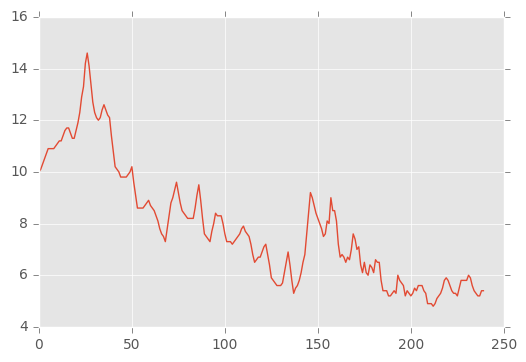

In [24]:
test_stationarity(df_var_t['umpr'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.360835
p-value                          0.153097
#Lags Used                      15.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


Results of KPSS Test:
Test Statistic            0.669004
p-value                   0.016363
#Lags Used               15.000000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
dtype: float64


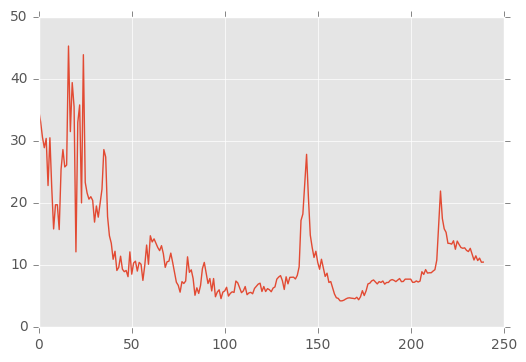

In [25]:
test_stationarity(df_var_t['stir'])

Results of Dickey-Fuller Test:
Test Statistic                -5.799629e+00
p-value                        4.663731e-07
#Lags Used                     2.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.527277
p-value                   0.035523
#Lags Used               15.000000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
dtype: float64


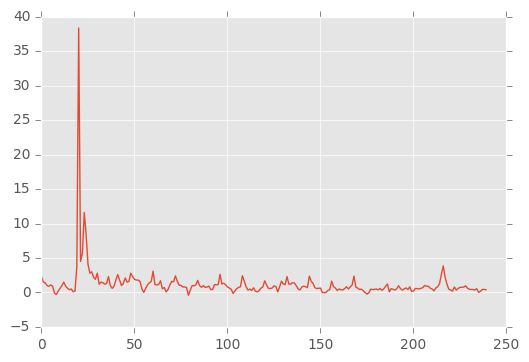

In [26]:
test_stationarity(df_var_t['infr'])

Рвзности

Results of Dickey-Fuller Test:
Test Statistic                  -3.425170
p-value                          0.010130
#Lags Used                      15.000000
Number of Observations Used    223.000000
Critical Value (1%)             -3.460019
Critical Value (5%)             -2.874590
Critical Value (10%)            -2.573725
dtype: float64


Results of KPSS Test:
Test Statistic            0.051855
p-value                   0.100000
#Lags Used               15.000000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


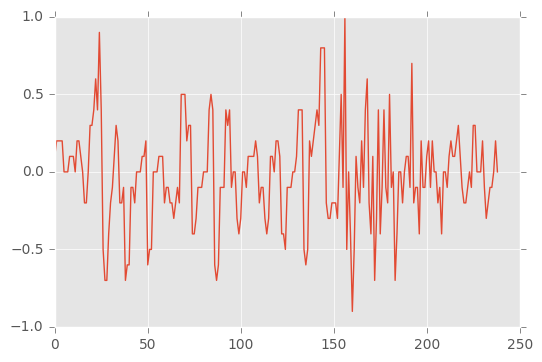

In [27]:
test_stationarity(diff_series(df_var_t['umpr']))

Results of Dickey-Fuller Test:
Test Statistic                  -5.087974
p-value                          0.000015
#Lags Used                      11.000000
Number of Observations Used    227.000000
Critical Value (1%)             -3.459490
Critical Value (5%)             -2.874358
Critical Value (10%)            -2.573602
dtype: float64


Results of KPSS Test:
Test Statistic            0.215061
p-value                   0.100000
#Lags Used               15.000000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


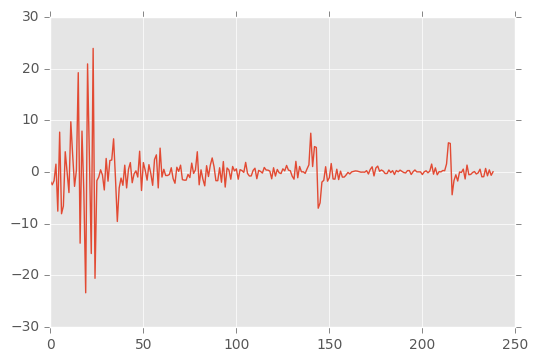

In [28]:
test_stationarity(diff_series(df_var_t['stir']))

Results of Dickey-Fuller Test:
Test Statistic                -1.462021e+01
p-value                        3.895774e-27
#Lags Used                     2.000000e+00
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.031833
p-value                   0.100000
#Lags Used               15.000000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


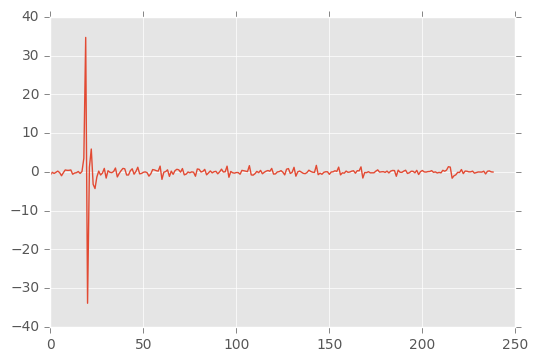

In [29]:
test_stationarity(diff_series(df_var_t['infr']))

In [30]:
df_var_t_diff = diff_series(df_var_t)

## Forecasting

In [31]:
STEPS = 8
LAG = 2

In [32]:
train = df_var_t_diff.iloc[:-STEPS, :]
test = df_var_t_diff.iloc[-STEPS:, :]

train_real = df_var_t.iloc[:-STEPS, :]
test_real = df_var_t.iloc[-STEPS:, :]

### VAR

In [33]:
def var_model(train, steps, lags, years=None, period='m'):
    df = np.array(train)
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model = VAR(df)
    fitm = model.fit(maxlags=lags)
    var_in = pd.DataFrame(fitm.fittedvalues, 
                          columns=train.columns, 
                          index=years)
    var_out = fitm.forecast(y=df, steps=steps)
    var_out = pd.DataFrame(var_out, 
                           columns=train.columns, 
                           index=years_out)
    return {'in':var_in, 'out':var_out}

In [34]:
var_result = var_model(train, steps=STEPS, lags=LAG, years=train.index[LAG:], period='m')
print(error(var_result['out']['stir'], test['stir']))
print(error(var_result['out']['infr'], test['infr']))
print(error(var_result['out']['umpr'], test['umpr']))

{'mse': 0.41590055615953847, 'mae': 0.60479459568172822, 'rmse': 0.64490352469151424}
{'mse': 0.048314330427319363, 'mae': 0.15487943016876288, 'rmse': 0.21980521019147695}
{'mse': 0.029474173284239621, 'mae': 0.13972046635164265, 'rmse': 0.17168043943396585}


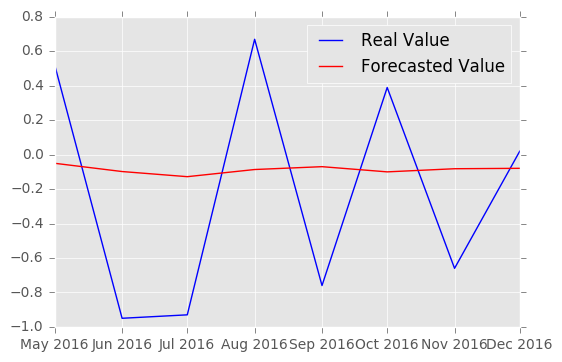

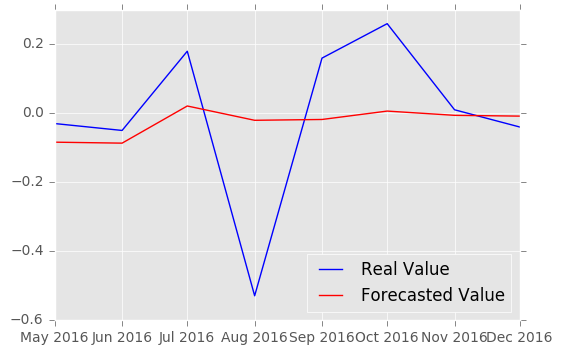

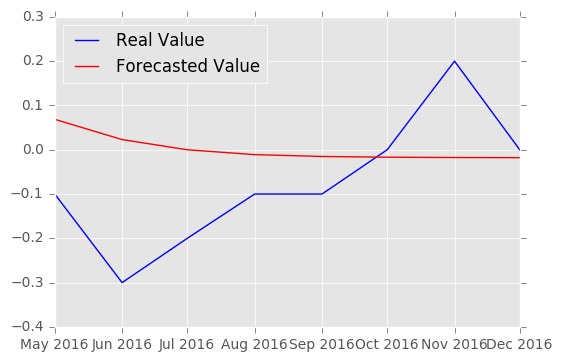

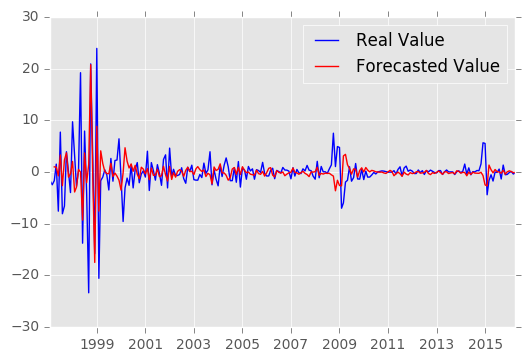

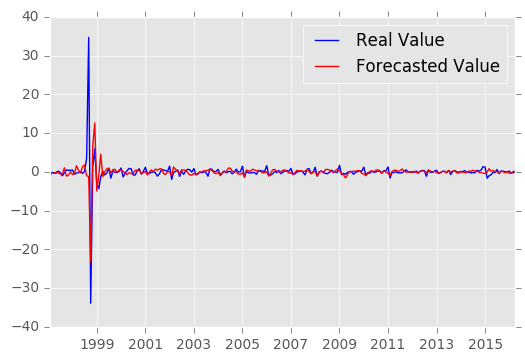

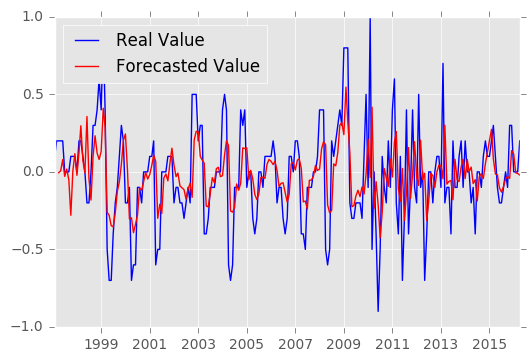

In [35]:
plot_compar(var_result['out']['stir'], test['stir'])
plot_compar(var_result['out']['infr'], test['infr'])
plot_compar(var_result['out']['umpr'], test['umpr'])
plot_compar(var_result['in']['stir'], train['stir'])
plot_compar(var_result['in']['infr'], train['infr'])
plot_compar(var_result['in']['umpr'], train['umpr'])

{'mse': 0.65532822941504065, 'mae': 0.74057153766819828, 'rmse': 0.80952345822405958}
{'mse': 0.0296895596344455, 'mae': 0.15670602923996307, 'rmse': 0.17230658616096339}
{'mse': 0.4501028972443043, 'mae': 0.63632196179986544, 'rmse': 0.67089708394380754}


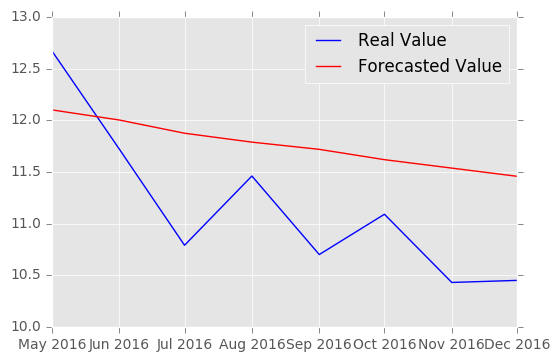

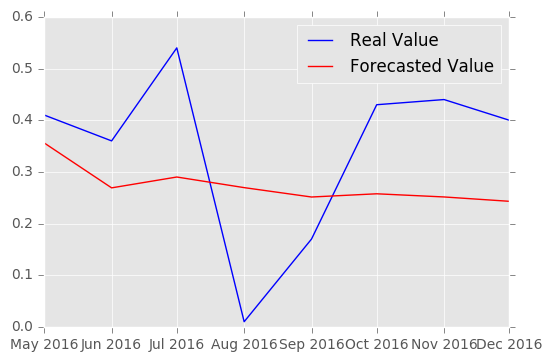

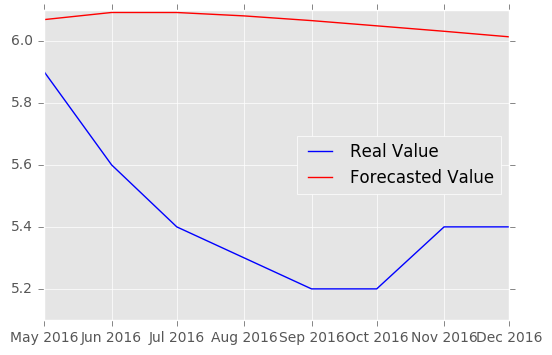

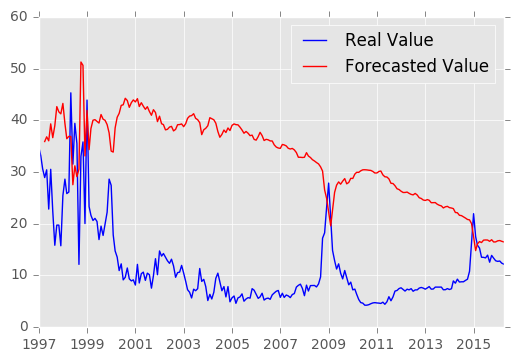

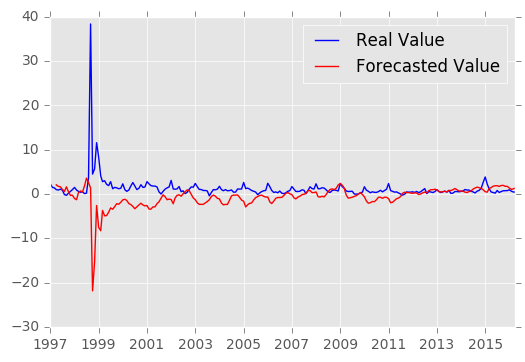

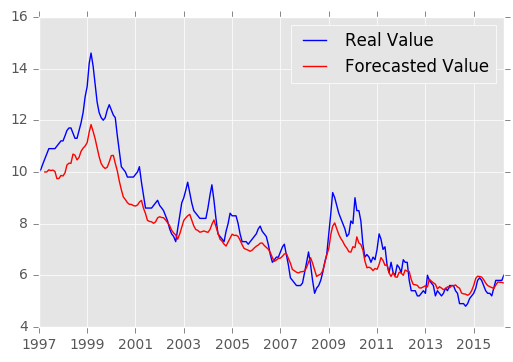

In [36]:
var_undiff_out = undiff(previous_df=train_real, diff_df=var_result['out'])
var_undiff_in = undiff(previous_df=train_real.head(1), diff_df=var_result['in'])
print(error(var_undiff_out['stir'], test_real['stir']))
print(error(var_undiff_out['infr'], test_real['infr']))
print(error(var_undiff_out['umpr'], test_real['umpr']))
plot_compar(var_undiff_out['stir'], test_real['stir'])
plot_compar(var_undiff_out['infr'], test_real['infr'])
plot_compar(var_undiff_out['umpr'], test_real['umpr'])
plot_compar(var_undiff_in['stir'], train_real['stir'])
plot_compar(var_undiff_in['infr'], train_real['infr'])
plot_compar(var_undiff_in['umpr'], train_real['umpr'])

## ANN

In [37]:
df_nn = nn_transform(train, n=LAG)
df_nn_s, m, s = scaler(df_nn)
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [38]:
def nn_model(x, y, n_feat, lag, steps, model, years=None, epoch=100, period='m'):
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model.fit(np.array(x), np.array(y),
       nb_epoch=epoch, 
       verbose=2,
       batch_size=1)
    nn_in = pd.DataFrame(model.predict(np.array(x)), 
                         columns=y.columns, 
                         index=years)
    nn_out = nn_predict(model, train, lags=lag, steps=steps)
    if years is not None:
        nn_out.index = years_out
    return {'in':nn_in, 'out':nn_out}

Первый запуск

In [39]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [40]:
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=500)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/500
1s - loss: 1.0648
Epoch 2/500
0s - loss: 0.9987
Epoch 3/500
0s - loss: 0.9872
Epoch 4/500
0s - loss: 0.9796
Epoch 5/500
0s - loss: 0.9711
Epoch 6/500
0s - loss: 0.9649
Epoch 7/500
0s - loss: 0.9575
Epoch 8/500
0s - loss: 0.9506
Epoch 9/500
0s - loss: 0.9439
Epoch 10/500
0s - loss: 0.9382
Epoch 11/500
0s - loss: 0.9310
Epoch 12/500
0s - loss: 0.9220
Epoch 13/500
0s - loss: 0.9186
Epoch 14/500
0s - loss: 0.9105
Epoch 15/500
0s - loss: 0.9088
Epoch 16/500
0s - loss: 0.9006
Epoch 17/500
0s - loss: 0.8995
Epoch 18/500
0s - loss: 0.8932
Epoch 19/500
0s - loss: 0.8898
Epoch 20/500
0s - loss: 0.8857
Epoch 21/500
0s - loss: 0.8836
Epoch 22/500
0s - loss: 0.8774
Epoch 23/500
0s - loss: 0.8787
Epoch 24/500
0s - loss: 0.8726
Epoch 25/500
0s - loss: 0.8684
Epoch 26/500
0s - loss: 0.8688
Epoch 27/500
0s - loss: 0.8662
Epoch 28/500
0s - loss: 0.8627
Epoch 29/500
0s - loss: 0.8609
Epoch 30/500
0s - loss: 0.8578
Epoch 31/500
0s - loss: 0.8563
Epoch 32/500
0s - loss: 0.8536
Epoch 33/500
0s -

{'mse': 1.2560528873278232, 'mae': 0.96112084121007846, 'rmse': 1.1207376532123043}
{'mse': 0.12987588012147835, 'mae': 0.2754615203504478, 'rmse': 0.36038296313987755}
{'mse': 0.020790955815613705, 'mae': 0.11596103860558465, 'rmse': 0.14419069254155659}


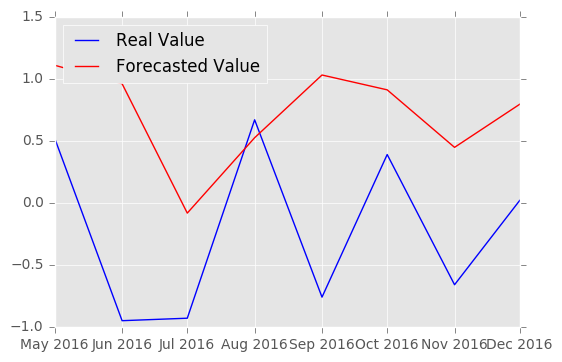

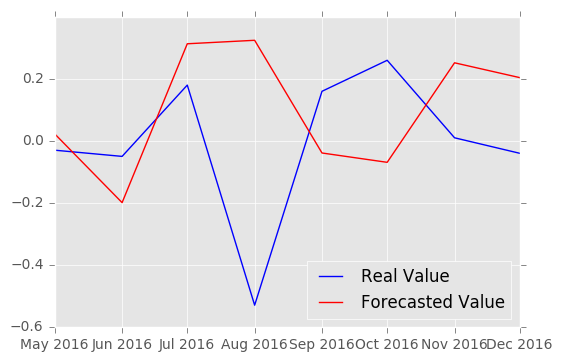

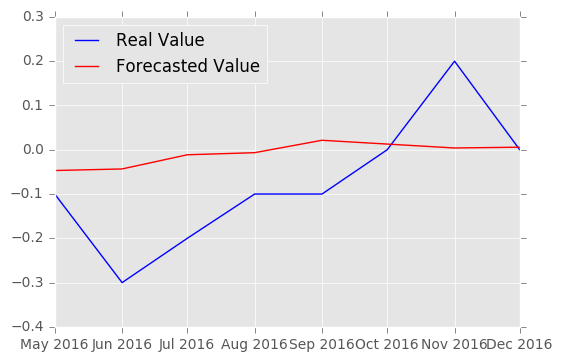

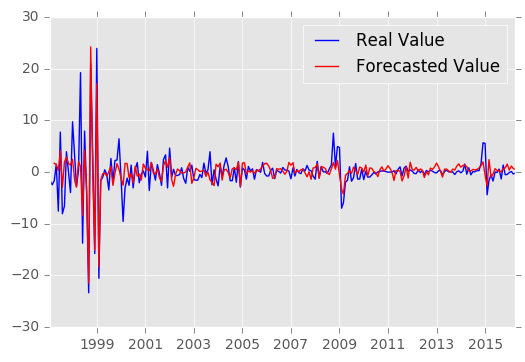

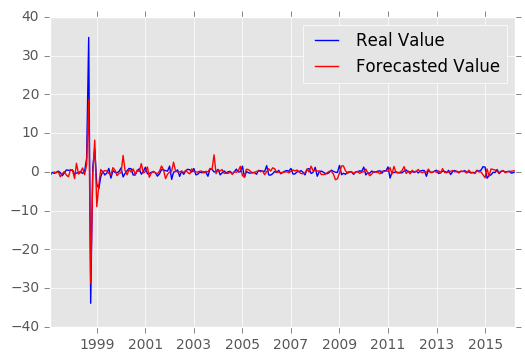

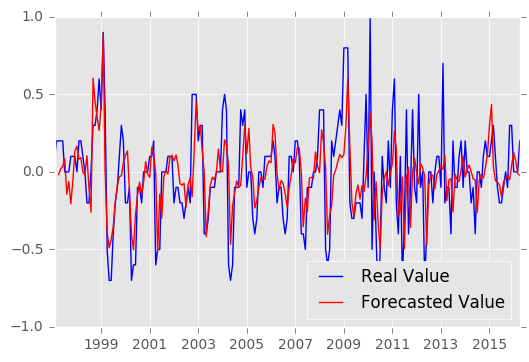

In [41]:
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['umpr'], test['umpr']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['umpr'], test['umpr'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['umpr'], train['umpr'])

{'mse': 22.765036827944233, 'mae': 4.2725107367163808, 'rmse': 4.7712720345778052}
{'mse': 0.31312908836974834, 'mae': 0.44824310171230353, 'rmse': 0.55957938522585726}
{'mse': 0.28754994966003949, 'mae': 0.49467887144011391, 'rmse': 0.53623684101340841}


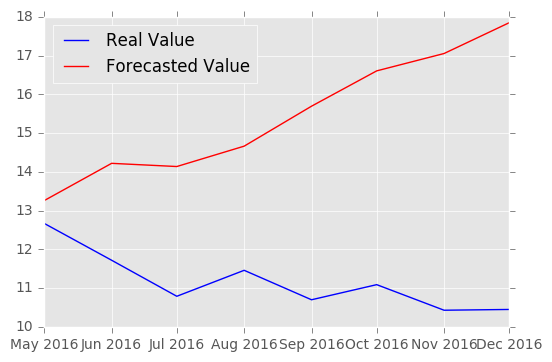

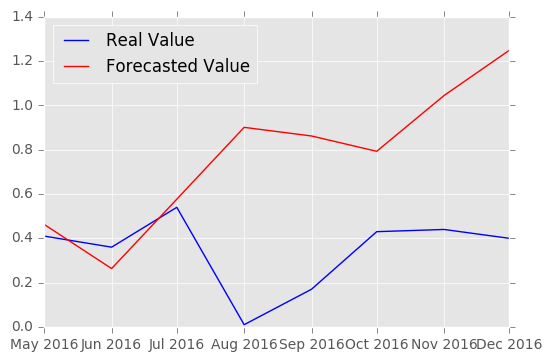

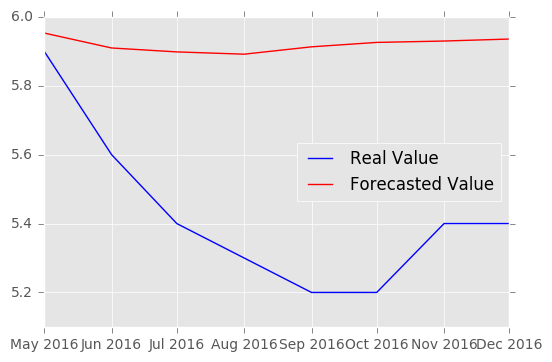

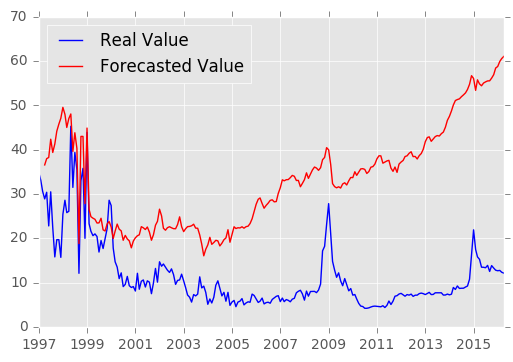

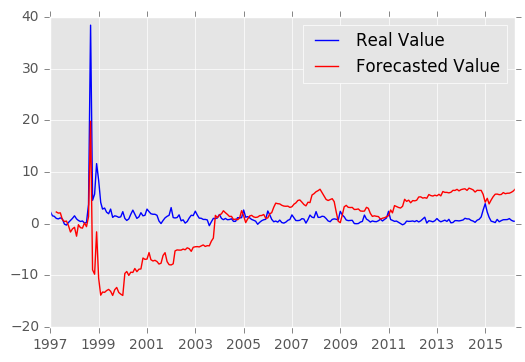

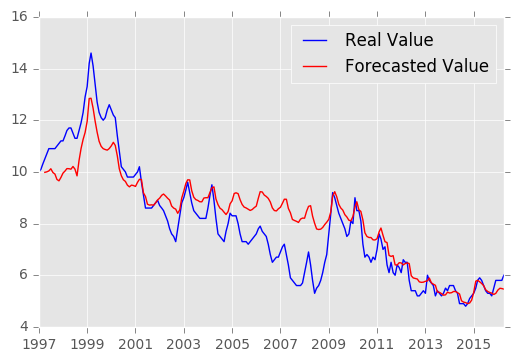

In [42]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['umpr'], test_real['umpr']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['umpr'], test_real['umpr'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['umpr'], train_real['umpr'])

Второй запуск

In [43]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 1.0039
Epoch 2/600
0s - loss: 0.9815
Epoch 3/600
0s - loss: 0.9740
Epoch 4/600
0s - loss: 0.9681
Epoch 5/600
0s - loss: 0.9584
Epoch 6/600
0s - loss: 0.9481
Epoch 7/600
0s - loss: 0.9415
Epoch 8/600
0s - loss: 0.9339
Epoch 9/600
0s - loss: 0.9281
Epoch 10/600
0s - loss: 0.9214
Epoch 11/600
0s - loss: 0.9180
Epoch 12/600
0s - loss: 0.9116
Epoch 13/600
0s - loss: 0.9077
Epoch 14/600
0s - loss: 0.9035
Epoch 15/600
0s - loss: 0.8972
Epoch 16/600
0s - loss: 0.8963
Epoch 17/600
0s - loss: 0.8943
Epoch 18/600
0s - loss: 0.8888
Epoch 19/600
0s - loss: 0.8873
Epoch 20/600
0s - loss: 0.8838
Epoch 21/600
0s - loss: 0.8828
Epoch 22/600
0s - loss: 0.8792
Epoch 23/600
0s - loss: 0.8742
Epoch 24/600
0s - loss: 0.8744
Epoch 25/600
0s - loss: 0.8703
Epoch 26/600
0s - loss: 0.8700
Epoch 27/600
0s - loss: 0.8667
Epoch 28/600
0s - loss: 0.8630
Epoch 29/600
0s - loss: 0.8593
Epoch 30/600
0s - loss: 0.8591
Epoch 31/600
0s - loss: 0.8577
Epoch 32/600
0s - loss: 0.8543
Epoch 33/600
0s -

{'mse': 0.81533651248684935, 'mae': 0.7459289421071652, 'rmse': 0.90295986205747225}
{'mse': 0.12256635261859014, 'mae': 0.26553179316338427, 'rmse': 0.35009477662283128}
{'mse': 0.022461906574692478, 'mae': 0.11690820551178539, 'rmse': 0.14987296812531764}


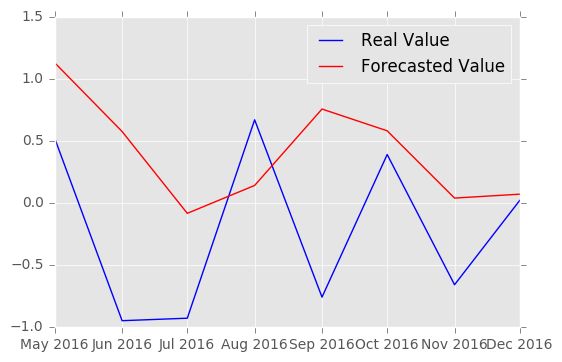

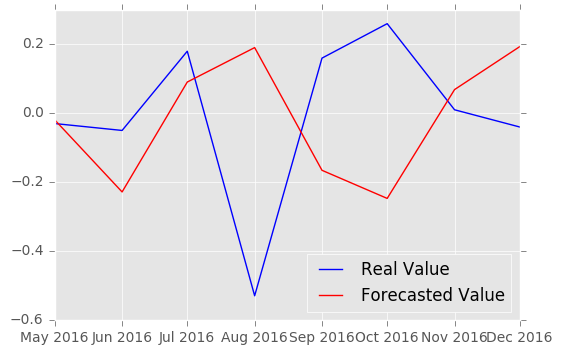

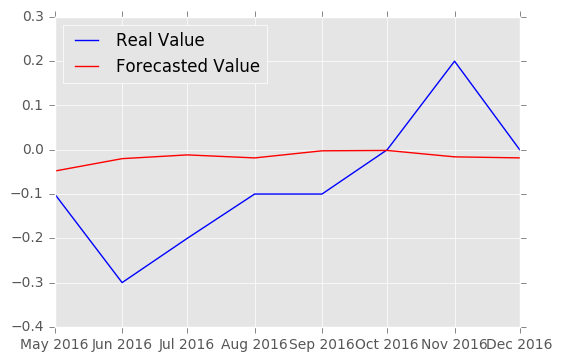

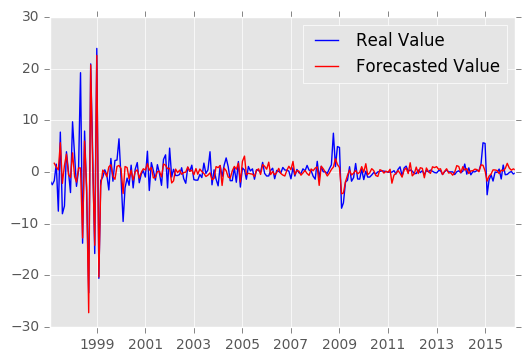

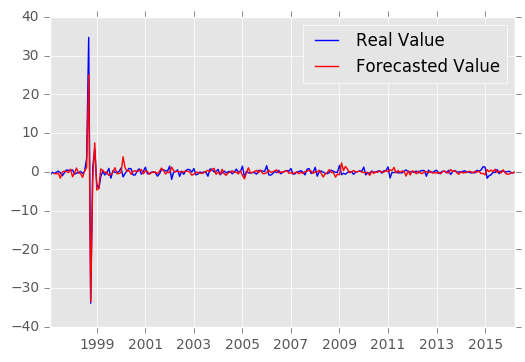

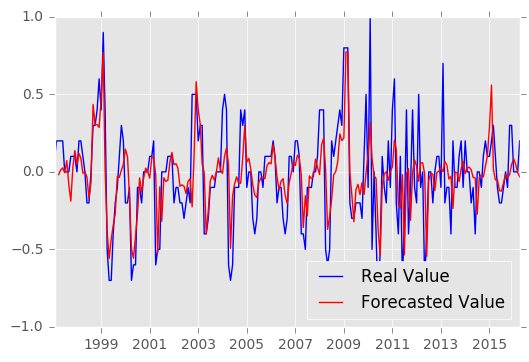

In [44]:
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['umpr'], test['umpr']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['umpr'], test['umpr'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['umpr'], train['umpr'])

{'mse': 12.573276088768464, 'mae': 3.2592077688637975, 'rmse': 3.5458815672225241}
{'mse': 0.070958709536082243, 'mae': 0.22443570721451522, 'rmse': 0.26638076044654996}
{'mse': 0.27097019512724335, 'mae': 0.48092721439062203, 'rmse': 0.52054797581706469}


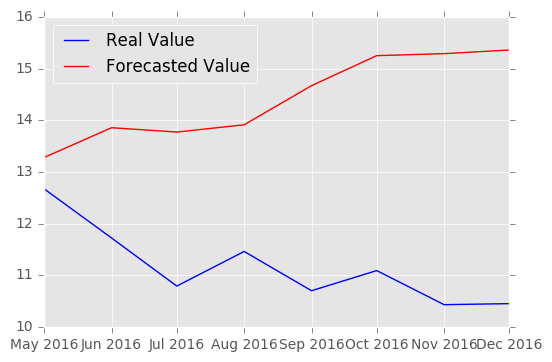

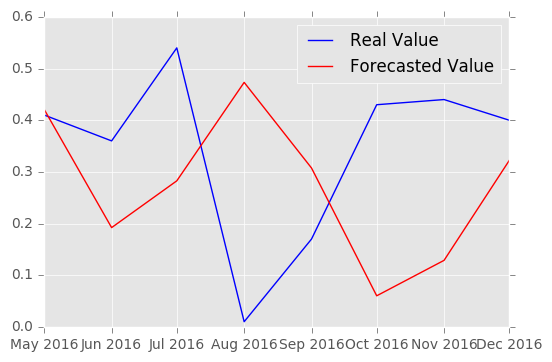

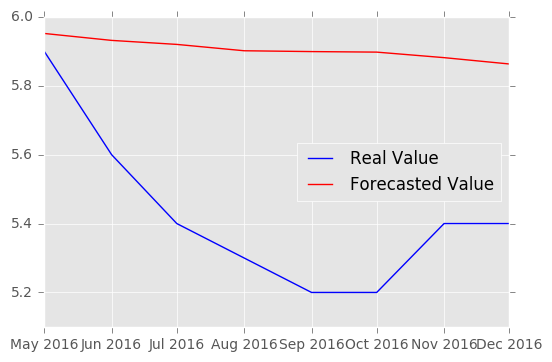

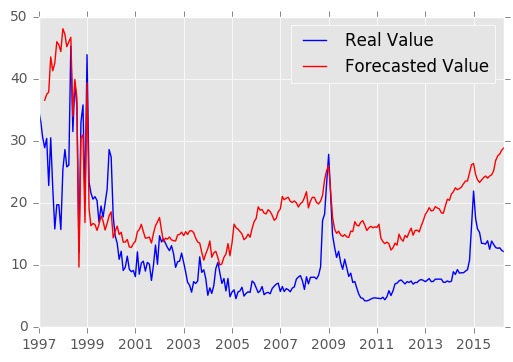

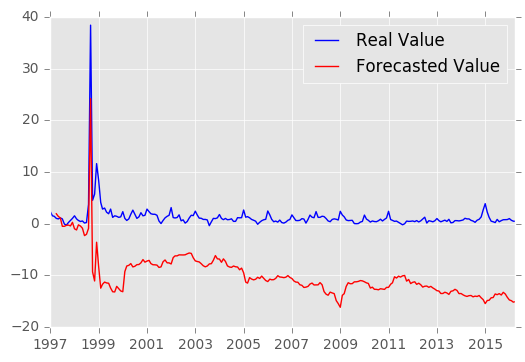

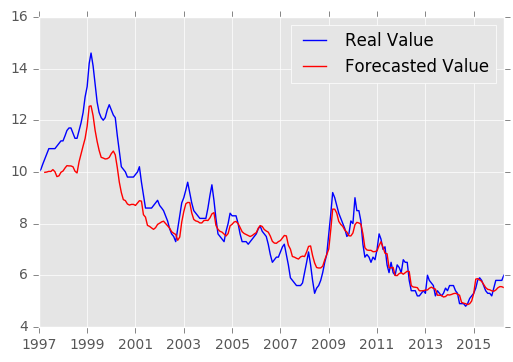

In [45]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['umpr'], test_real['umpr']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['umpr'], test_real['umpr'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['umpr'], train_real['umpr'])

С DropOut

In [46]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
1s - loss: 1.0364
Epoch 2/600
0s - loss: 1.0206
Epoch 3/600
0s - loss: 1.0303
Epoch 4/600
0s - loss: 1.0006
Epoch 5/600
0s - loss: 1.0170
Epoch 6/600
0s - loss: 1.0073
Epoch 7/600
0s - loss: 1.0103
Epoch 8/600
0s - loss: 1.0010
Epoch 9/600
0s - loss: 1.0089
Epoch 10/600
0s - loss: 0.9919
Epoch 11/600
0s - loss: 0.9795
Epoch 12/600
0s - loss: 0.9987
Epoch 13/600
0s - loss: 0.9928
Epoch 14/600
0s - loss: 0.9953
Epoch 15/600
0s - loss: 0.9974
Epoch 16/600
0s - loss: 0.9965
Epoch 17/600
0s - loss: 0.9892
Epoch 18/600
0s - loss: 0.9859
Epoch 19/600
0s - loss: 0.9799
Epoch 20/600
0s - loss: 0.9759
Epoch 21/600
0s - loss: 0.9831
Epoch 22/600
0s - loss: 0.9699
Epoch 23/600
0s - loss: 0.9641
Epoch 24/600
0s - loss: 0.9751
Epoch 25/600
0s - loss: 0.9738
Epoch 26/600
0s - loss: 0.9583
Epoch 27/600
0s - loss: 0.9673
Epoch 28/600
0s - loss: 0.9636
Epoch 29/600
0s - loss: 0.9658
Epoch 30/600
0s - loss: 0.9549
Epoch 31/600
0s - loss: 0.9355
Epoch 32/600
0s - loss: 0.9630
Epoch 33/600
0s -

{'mse': 0.72366356648849339, 'mae': 0.69242224970439137, 'rmse': 0.85068417552490849}
{'mse': 0.090912155565079006, 'mae': 0.2793254574568837, 'rmse': 0.30151642669194495}
{'mse': 0.029392867144469589, 'mae': 0.14580817230354678, 'rmse': 0.17144348090396902}


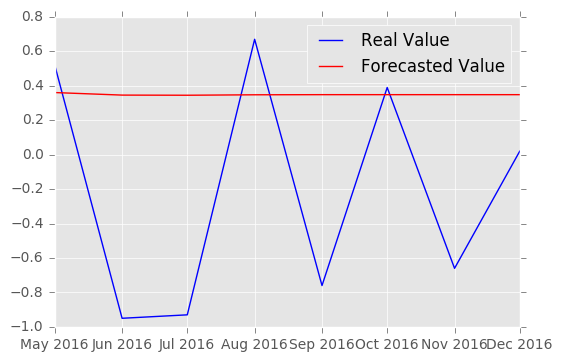

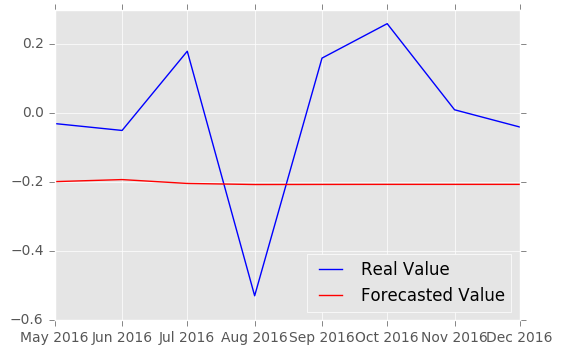

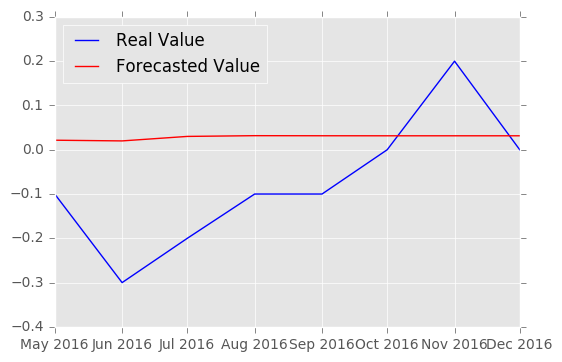

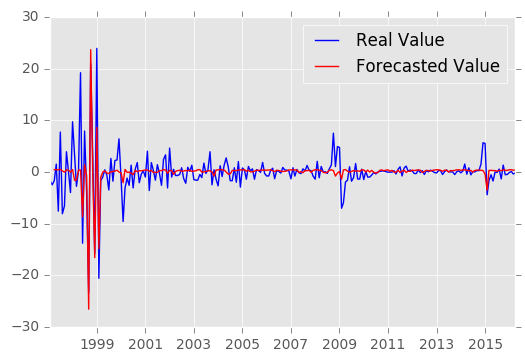

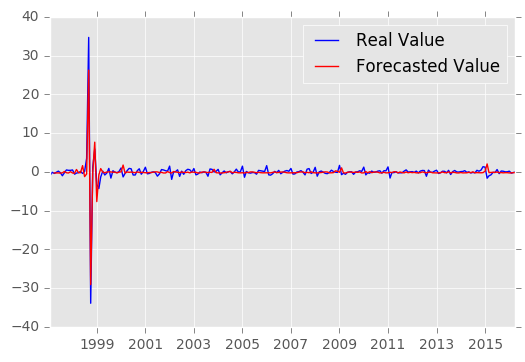

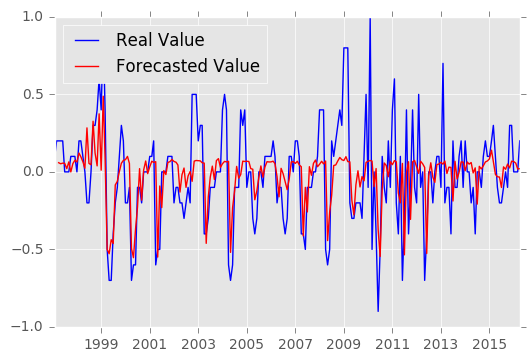

In [47]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['umpr'], test['umpr']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['umpr'], test['umpr'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['umpr'], train['umpr'])

{'mse': 8.6514091374548343, 'mae': 2.6009555839715262, 'rmse': 2.9413277847691228}
{'mse': 0.91146886591827436, 'mae': 0.81276276190385688, 'rmse': 0.95470878592284592}
{'mse': 0.55488692739935963, 'mae': 0.69585455564637999, 'rmse': 0.74490732806125592}


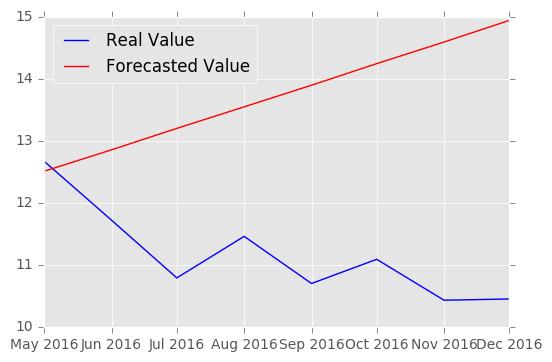

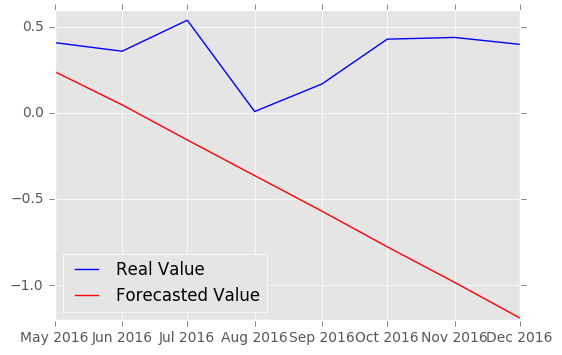

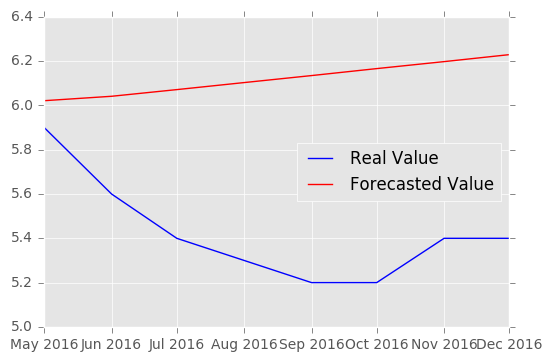

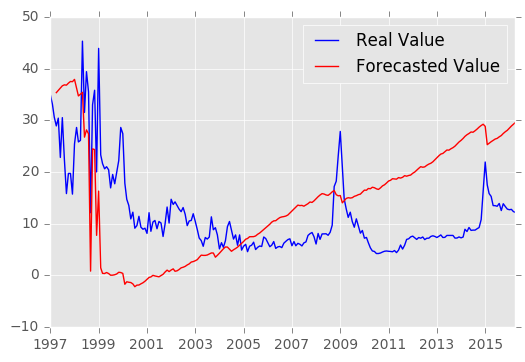

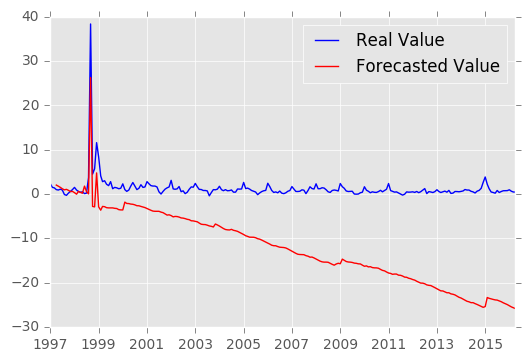

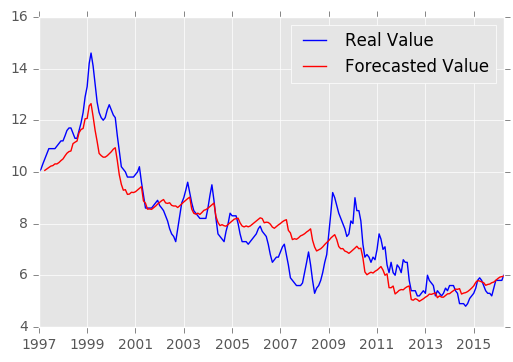

In [48]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['umpr'], test_real['umpr']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['umpr'], test_real['umpr'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['umpr'], train_real['umpr'])

На оригинальных данных, а не разницах

In [49]:
df_nn = nn_transform(train_real, n=LAG)
df_nn_s, m, s = scaler(df_nn)
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [50]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.2736
Epoch 2/600
0s - loss: 0.9518
Epoch 3/600
0s - loss: 0.8713
Epoch 4/600
0s - loss: 0.7859
Epoch 5/600
0s - loss: 0.6921
Epoch 6/600
0s - loss: 0.6059
Epoch 7/600
0s - loss: 0.5471
Epoch 8/600
0s - loss: 0.5107
Epoch 9/600
0s - loss: 0.4863
Epoch 10/600
0s - loss: 0.4692
Epoch 11/600
0s - loss: 0.4535
Epoch 12/600
0s - loss: 0.4397
Epoch 13/600
0s - loss: 0.4275
Epoch 14/600
0s - loss: 0.4171
Epoch 15/600
0s - loss: 0.4078
Epoch 16/600
0s - loss: 0.4000
Epoch 17/600
0s - loss: 0.3929
Epoch 18/600
0s - loss: 0.3880
Epoch 19/600
0s - loss: 0.3834
Epoch 20/600
0s - loss: 0.3803
Epoch 21/600
0s - loss: 0.3783
Epoch 22/600
0s - loss: 0.3747
Epoch 23/600
0s - loss: 0.3736
Epoch 24/600
0s - loss: 0.3715
Epoch 25/600
0s - loss: 0.3698
Epoch 26/600
0s - loss: 0.3691
Epoch 27/600
0s - loss: 0.3686
Epoch 28/600
0s - loss: 0.3678
Epoch 29/600
0s - loss: 0.3664
Epoch 30/600
0s - loss: 0.3667
Epoch 31/600
0s - loss: 0.3651
Epoch 32/600
0s - loss: 0.3638
Epoch 33/600
0s -

{'mse': 23.899668657900936, 'mae': 4.8786381444515481, 'rmse': 4.8887287363793188}
{'mse': 0.60550776940088213, 'mae': 0.73154633243922118, 'rmse': 0.77814379737994577}
{'mse': 7.9595431317593359, 'mae': 2.8123447502939509, 'rmse': 2.8212662284441246}


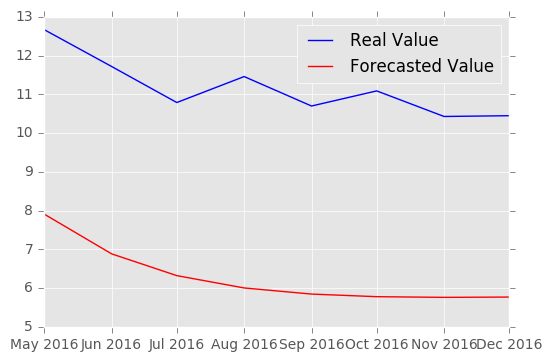

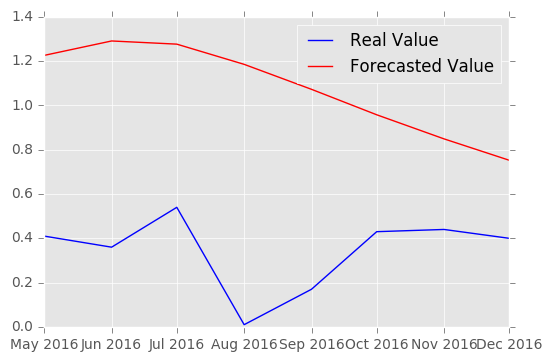

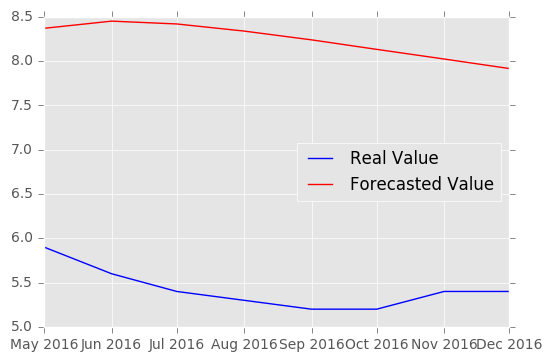

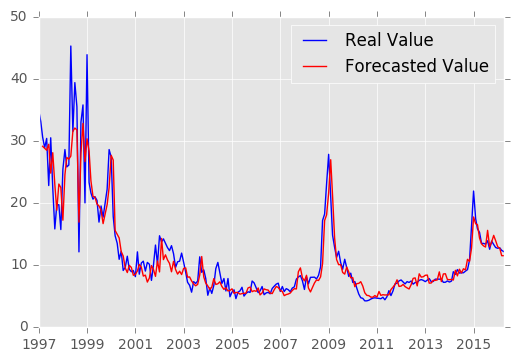

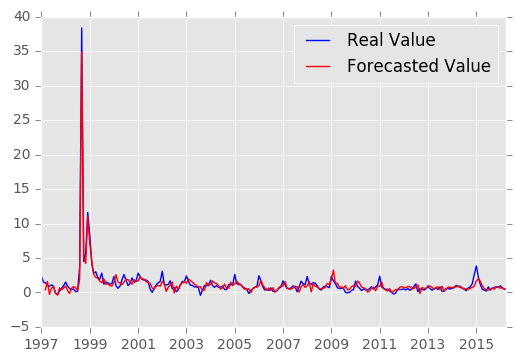

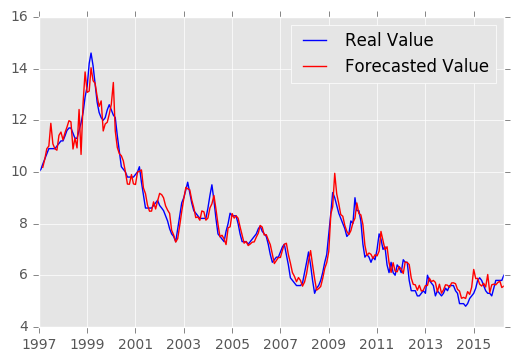

In [51]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['umpr'], test_real['umpr']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['umpr'], test_real['umpr'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['umpr'], train_real['umpr'])

Второй запуск (не на разницах)

In [52]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
1s - loss: 1.1051
Epoch 2/600
0s - loss: 0.8729
Epoch 3/600
0s - loss: 0.7725
Epoch 4/600
0s - loss: 0.6863
Epoch 5/600
0s - loss: 0.6192
Epoch 6/600
0s - loss: 0.5776
Epoch 7/600
0s - loss: 0.5502
Epoch 8/600
0s - loss: 0.5334
Epoch 9/600
0s - loss: 0.5197
Epoch 10/600
0s - loss: 0.5099
Epoch 11/600
0s - loss: 0.5018
Epoch 12/600
0s - loss: 0.4933
Epoch 13/600
0s - loss: 0.4847
Epoch 14/600
0s - loss: 0.4770
Epoch 15/600
0s - loss: 0.4681
Epoch 16/600
0s - loss: 0.4605
Epoch 17/600
0s - loss: 0.4515
Epoch 18/600
0s - loss: 0.4415
Epoch 19/600
0s - loss: 0.4326
Epoch 20/600
0s - loss: 0.4240
Epoch 21/600
0s - loss: 0.4150
Epoch 22/600
0s - loss: 0.4060
Epoch 23/600
0s - loss: 0.3974
Epoch 24/600
0s - loss: 0.3902
Epoch 25/600
0s - loss: 0.3845
Epoch 26/600
0s - loss: 0.3799
Epoch 27/600
0s - loss: 0.3746
Epoch 28/600
0s - loss: 0.3739
Epoch 29/600
0s - loss: 0.3708
Epoch 30/600
0s - loss: 0.3686
Epoch 31/600
0s - loss: 0.3655
Epoch 32/600
0s - loss: 0.3653
Epoch 33/600
0s -

{'mse': 18.800051922924489, 'mae': 4.2920618602996345, 'rmse': 4.3359026652964072}
{'mse': 0.51940779114771418, 'mae': 0.67084667738130976, 'rmse': 0.72069951515712438}
{'mse': 7.9118602774355296, 'mae': 2.8026142206907645, 'rmse': 2.8128029218975739}


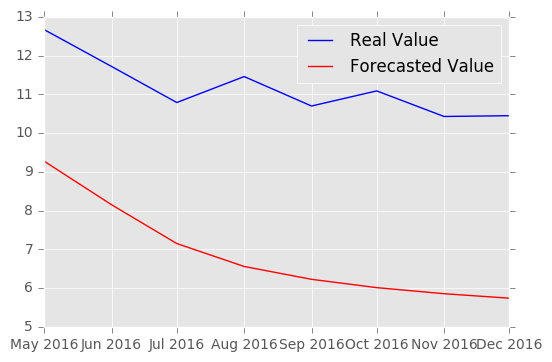

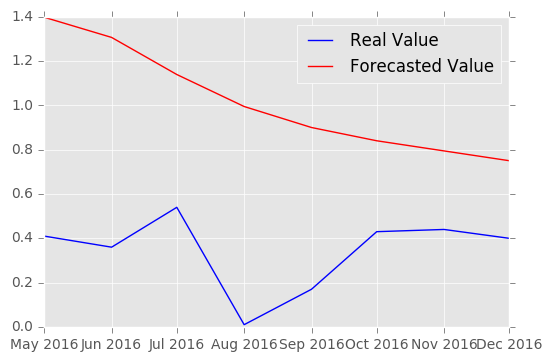

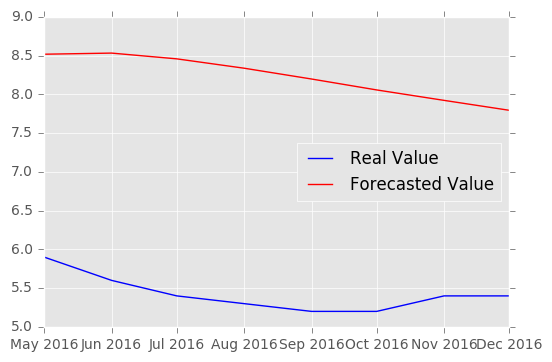

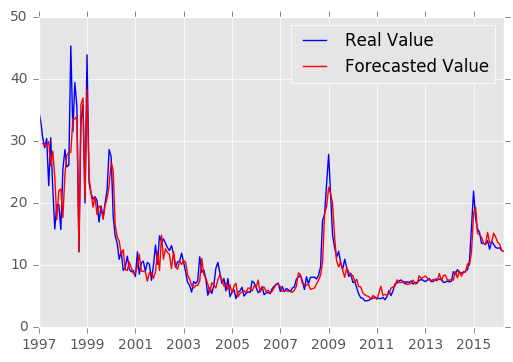

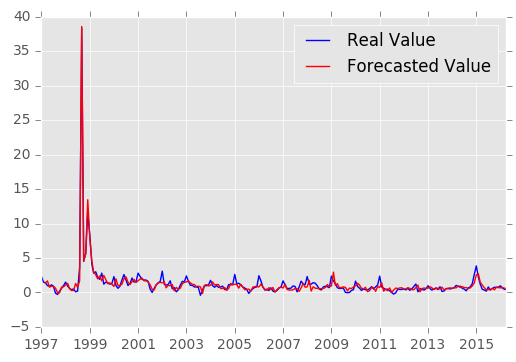

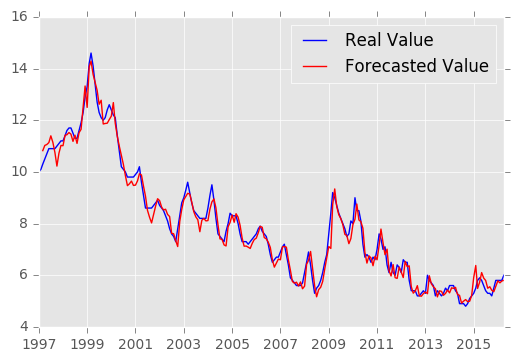

In [53]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['umpr'], test_real['umpr']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['umpr'], test_real['umpr'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['umpr'], train_real['umpr'])

С DropOut

In [54]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
1s - loss: 1.1281
Epoch 2/600
0s - loss: 0.9176
Epoch 3/600
0s - loss: 0.8327
Epoch 4/600
0s - loss: 0.7357
Epoch 5/600
0s - loss: 0.6488
Epoch 6/600
0s - loss: 0.5859
Epoch 7/600
0s - loss: 0.5457
Epoch 8/600
0s - loss: 0.5225
Epoch 9/600
0s - loss: 0.5081
Epoch 10/600
0s - loss: 0.4972
Epoch 11/600
0s - loss: 0.4890
Epoch 12/600
0s - loss: 0.4822
Epoch 13/600
0s - loss: 0.4766
Epoch 14/600
0s - loss: 0.4704
Epoch 15/600
0s - loss: 0.4642
Epoch 16/600
0s - loss: 0.4581
Epoch 17/600
0s - loss: 0.4512
Epoch 18/600
0s - loss: 0.4449
Epoch 19/600
0s - loss: 0.4371
Epoch 20/600
0s - loss: 0.4285
Epoch 21/600
0s - loss: 0.4214
Epoch 22/600
0s - loss: 0.4130
Epoch 23/600
0s - loss: 0.4069
Epoch 24/600
0s - loss: 0.3994
Epoch 25/600
0s - loss: 0.3919
Epoch 26/600
0s - loss: 0.3871
Epoch 27/600
0s - loss: 0.3817
Epoch 28/600
0s - loss: 0.3780
Epoch 29/600
0s - loss: 0.3764
Epoch 30/600
0s - loss: 0.3743
Epoch 31/600
0s - loss: 0.3715
Epoch 32/600
0s - loss: 0.3712
Epoch 33/600
0s -

{'mse': 22.794059609424302, 'mae': 4.6681654427582178, 'rmse': 4.774312475050654}
{'mse': 0.20175159553702049, 'mae': 0.35251569903620278, 'rmse': 0.44916766973705985}
{'mse': 4.3650810805724731, 'mae': 2.0000380162281708, 'rmse': 2.0892776456403475}


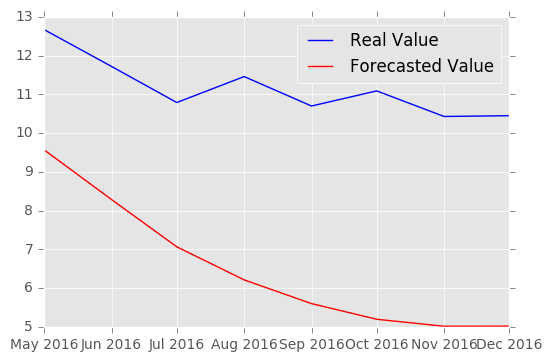

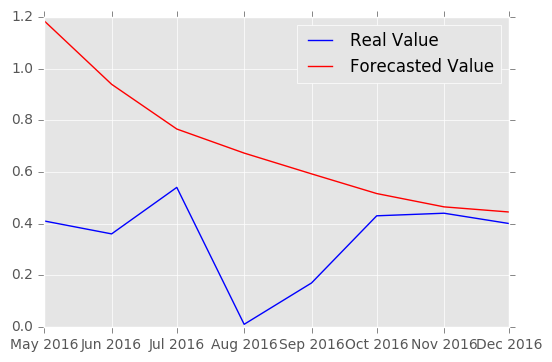

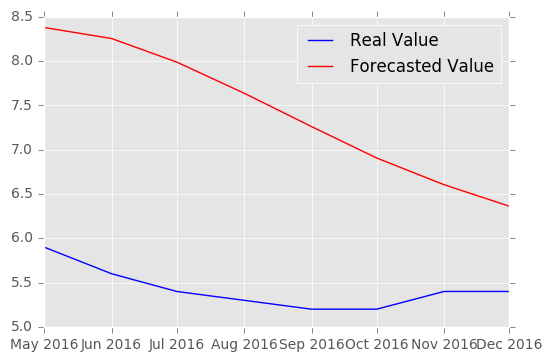

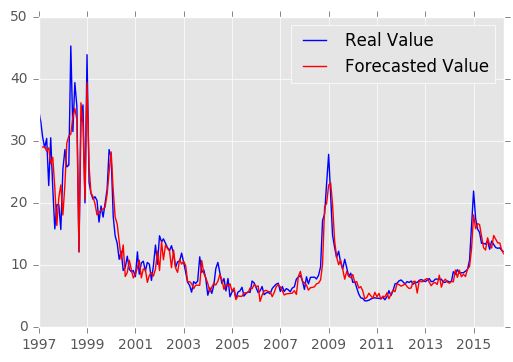

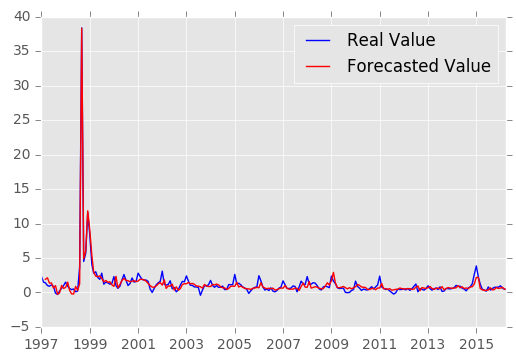

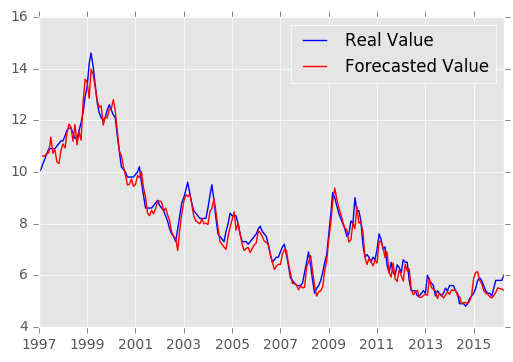

In [55]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['umpr'], test_real['umpr']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['umpr'], test_real['umpr'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['umpr'], train_real['umpr'])

## Hybrid

In [56]:
def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    
    resid_df = pd.DataFrame(fitm.resid)
    resid_df.columns = train.columns
    
    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_result + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

In [57]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [58]:
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='m')

Epoch 1/200
1s - loss: 1.0587
Epoch 2/200
0s - loss: 1.0038
Epoch 3/200
0s - loss: 1.0009
Epoch 4/200
0s - loss: 1.0000
Epoch 5/200
0s - loss: 0.9985
Epoch 6/200
0s - loss: 0.9989
Epoch 7/200
0s - loss: 0.9972
Epoch 8/200
0s - loss: 0.9964
Epoch 9/200
0s - loss: 0.9963
Epoch 10/200
0s - loss: 0.9930
Epoch 11/200
0s - loss: 0.9939
Epoch 12/200
0s - loss: 0.9941
Epoch 13/200
0s - loss: 0.9922
Epoch 14/200
0s - loss: 0.9927
Epoch 15/200
0s - loss: 0.9889
Epoch 16/200
0s - loss: 0.9900
Epoch 17/200
0s - loss: 0.9869
Epoch 18/200
0s - loss: 0.9860
Epoch 19/200
0s - loss: 0.9854
Epoch 20/200
0s - loss: 0.9831
Epoch 21/200
0s - loss: 0.9829
Epoch 22/200
0s - loss: 0.9807
Epoch 23/200
0s - loss: 0.9790
Epoch 24/200
0s - loss: 0.9771
Epoch 25/200
0s - loss: 0.9757
Epoch 26/200
0s - loss: 0.9743
Epoch 27/200
0s - loss: 0.9705
Epoch 28/200
0s - loss: 0.9710
Epoch 29/200
0s - loss: 0.9700
Epoch 30/200
0s - loss: 0.9678
Epoch 31/200
0s - loss: 0.9655
Epoch 32/200
0s - loss: 0.9628
Epoch 33/200
0s -

{'mse': 1.806311174148719, 'mae': 1.1674976248937325, 'rmse': 1.3439907641604978}
{'mse': 0.16999333666150473, 'mae': 0.37972681068127878, 'rmse': 0.41230248199774971}
{'mse': 0.030689955698360138, 'mae': 0.14336327044149233, 'rmse': 0.1751854894058299}


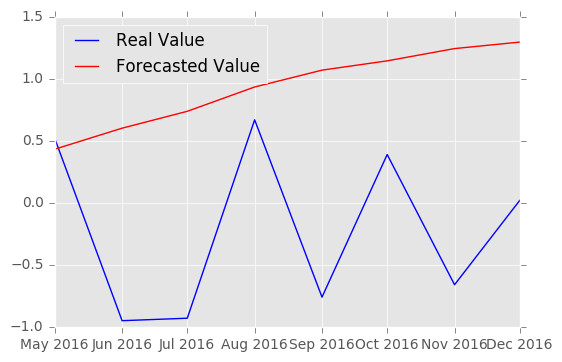

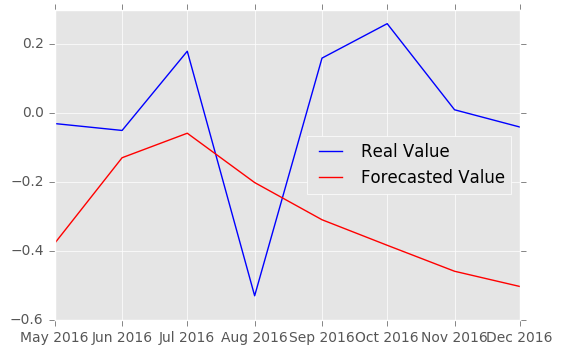

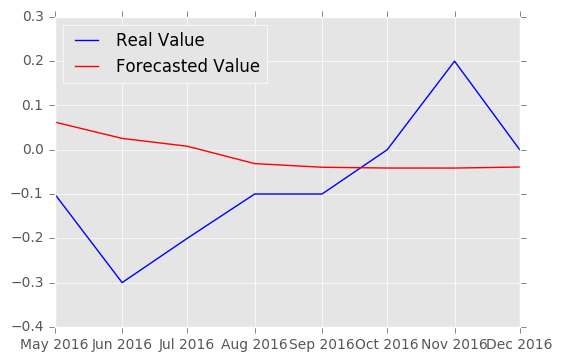

In [59]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'mse': 29.117094081526957, 'mae': 4.5442301783148107, 'rmse': 5.3960257673149554}
{'mse': 1.6185087362032349, 'mae': 1.0408666529613573, 'rmse': 1.2722062475099054}
{'mse': 0.39723530072430957, 'mae': 0.59587586213490451, 'rmse': 0.63026605550696568}


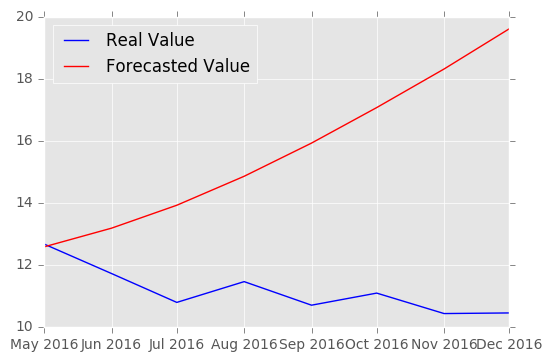

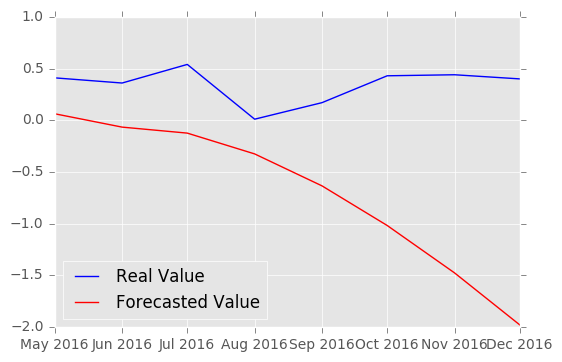

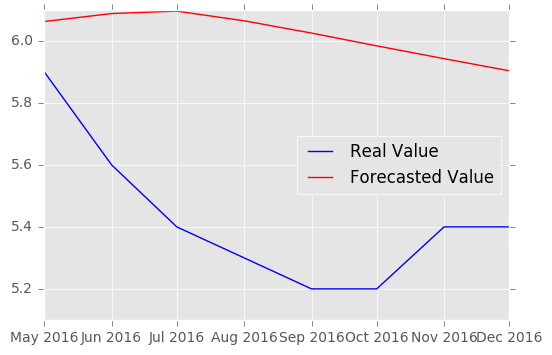

In [60]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

Второй запуск

In [61]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='m')

Epoch 1/200
1s - loss: 1.0198
Epoch 2/200
0s - loss: 1.0007
Epoch 3/200
0s - loss: 0.9989
Epoch 4/200
0s - loss: 0.9982
Epoch 5/200
0s - loss: 0.9955
Epoch 6/200
0s - loss: 0.9941
Epoch 7/200
0s - loss: 0.9948
Epoch 8/200
0s - loss: 0.9932
Epoch 9/200
0s - loss: 0.9946
Epoch 10/200
0s - loss: 0.9916
Epoch 11/200
0s - loss: 0.9898
Epoch 12/200
0s - loss: 0.9856
Epoch 13/200
0s - loss: 0.9867
Epoch 14/200
0s - loss: 0.9856
Epoch 15/200
0s - loss: 0.9826
Epoch 16/200
0s - loss: 0.9827
Epoch 17/200
0s - loss: 0.9807
Epoch 18/200
0s - loss: 0.9797
Epoch 19/200
0s - loss: 0.9780
Epoch 20/200
0s - loss: 0.9747
Epoch 21/200
0s - loss: 0.9758
Epoch 22/200
0s - loss: 0.9727
Epoch 23/200
0s - loss: 0.9724
Epoch 24/200
0s - loss: 0.9700
Epoch 25/200
0s - loss: 0.9685
Epoch 26/200
0s - loss: 0.9668
Epoch 27/200
0s - loss: 0.9648
Epoch 28/200
0s - loss: 0.9628
Epoch 29/200
0s - loss: 0.9610
Epoch 30/200
0s - loss: 0.9624
Epoch 31/200
0s - loss: 0.9594
Epoch 32/200
0s - loss: 0.9579
Epoch 33/200
0s -

{'mse': 1.4206326918139984, 'mae': 1.0456936206185581, 'rmse': 1.1919029708050897}
{'mse': 0.40331834161180363, 'mae': 0.55846645814096596, 'rmse': 0.6350734930791897}
{'mse': 0.027023749769387918, 'mae': 0.13406002305270873, 'rmse': 0.16438901961319655}


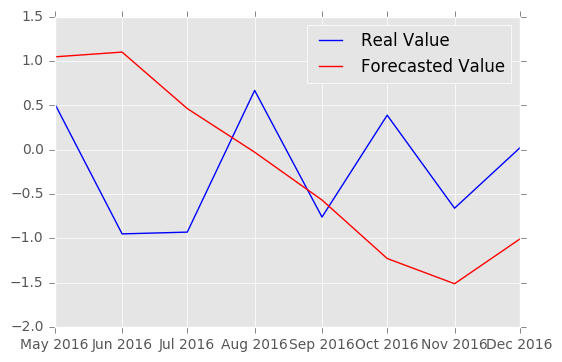

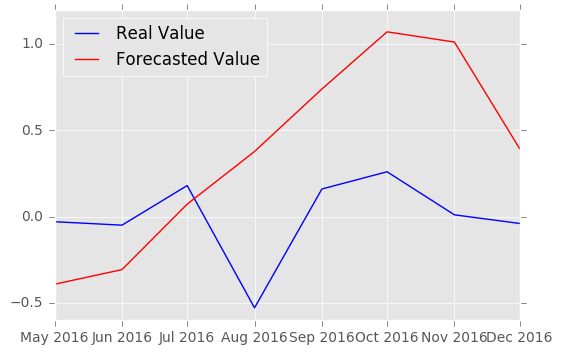

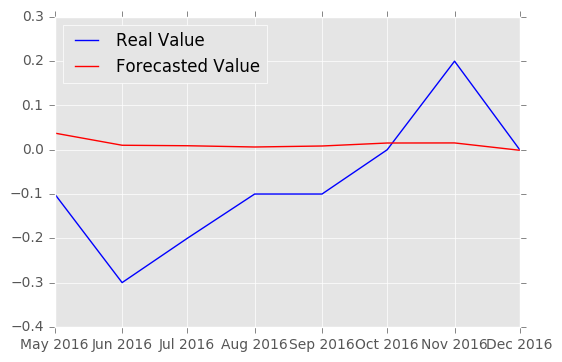

In [62]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'mse': 6.2490442551414453, 'mae': 2.0898884006176992, 'rmse': 2.4998088437201442}
{'mse': 2.4764415441483392, 'mae': 1.2257893463539173, 'rmse': 1.5736713583681756}
{'mse': 0.47034231486588252, 'mae': 0.64577308393934152, 'rmse': 0.68581507337319625}


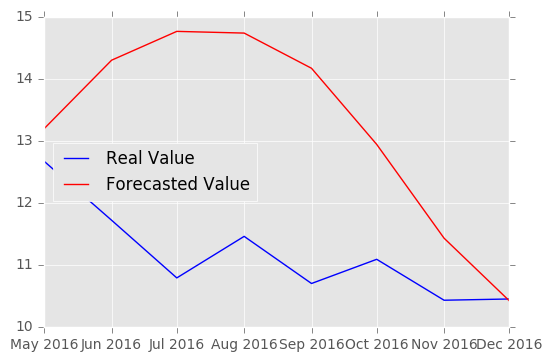

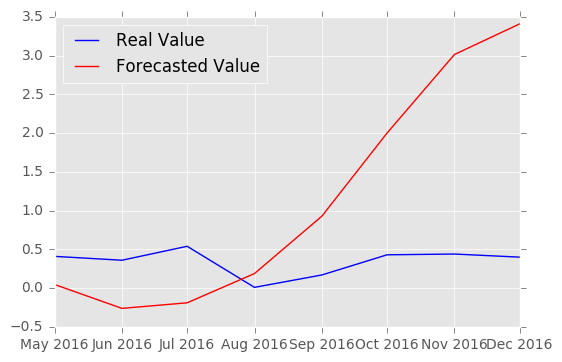

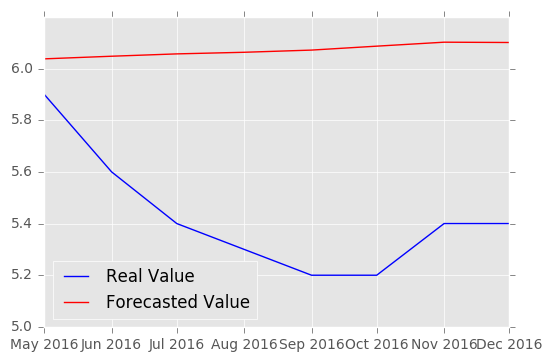

In [63]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

С DropOut

In [64]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='m')

Epoch 1/200
1s - loss: 1.0889
Epoch 2/200
0s - loss: 1.0080
Epoch 3/200
0s - loss: 1.0206
Epoch 4/200
0s - loss: 0.9996
Epoch 5/200
0s - loss: 1.0024
Epoch 6/200
0s - loss: 1.0067
Epoch 7/200
0s - loss: 1.0012
Epoch 8/200
0s - loss: 1.0021
Epoch 9/200
0s - loss: 1.0024
Epoch 10/200
0s - loss: 1.0117
Epoch 11/200
0s - loss: 1.0016
Epoch 12/200
0s - loss: 0.9992
Epoch 13/200
0s - loss: 1.0072
Epoch 14/200
0s - loss: 0.9963
Epoch 15/200
0s - loss: 0.9963
Epoch 16/200
0s - loss: 0.9977
Epoch 17/200
0s - loss: 0.9997
Epoch 18/200
0s - loss: 0.9975
Epoch 19/200
0s - loss: 1.0033
Epoch 20/200
0s - loss: 1.0039
Epoch 21/200
0s - loss: 1.0028
Epoch 22/200
0s - loss: 1.0043
Epoch 23/200
0s - loss: 1.0007
Epoch 24/200
0s - loss: 0.9965
Epoch 25/200
0s - loss: 0.9944
Epoch 26/200
0s - loss: 0.9985
Epoch 27/200
0s - loss: 0.9979
Epoch 28/200
0s - loss: 0.9946
Epoch 29/200
0s - loss: 0.9896
Epoch 30/200
0s - loss: 1.0021
Epoch 31/200
0s - loss: 0.9913
Epoch 32/200
0s - loss: 1.0002
Epoch 33/200
0s -

{'mse': 0.67908765327443188, 'mae': 0.67484594439424028, 'rmse': 0.82406774798825366}
{'mse': 0.054120664977196822, 'mae': 0.18685602488758238, 'rmse': 0.2326384855891149}
{'mse': 0.026816343590869714, 'mae': 0.1346941369425616, 'rmse': 0.16375696501483444}


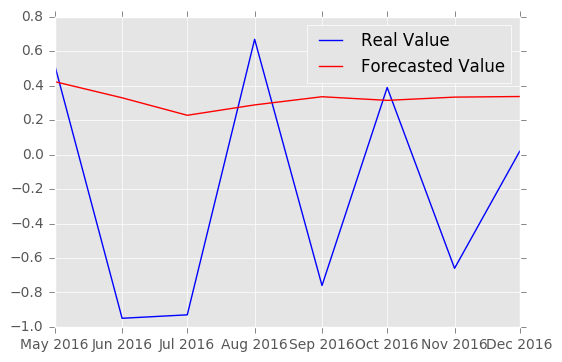

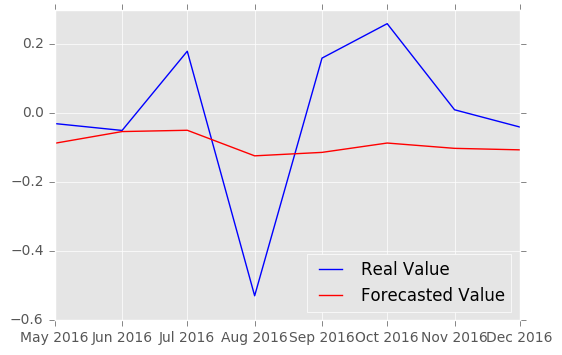

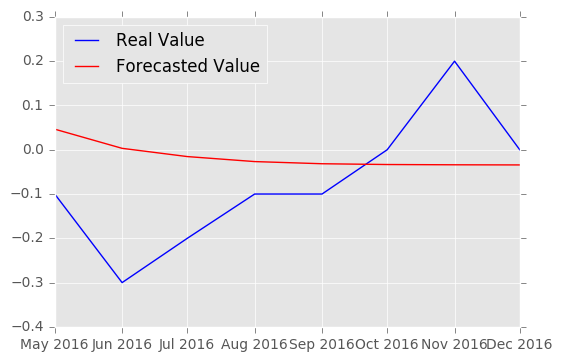

In [65]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'mse': 7.9094007412777749, 'mae': 2.4874591135281072, 'rmse': 2.8123656841310263}
{'mse': 0.15354308602213157, 'mae': 0.31047530371654808, 'rmse': 0.39184574263622102}
{'mse': 0.3454587394686513, 'mae': 0.55491751706022407, 'rmse': 0.58775738146675049}


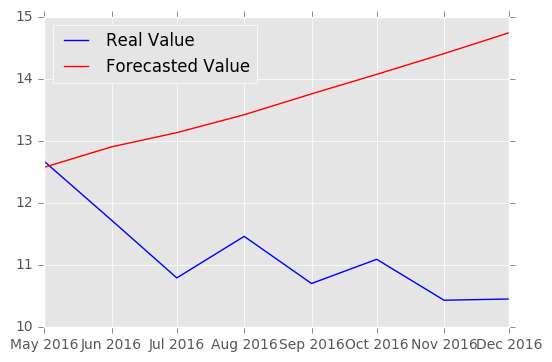

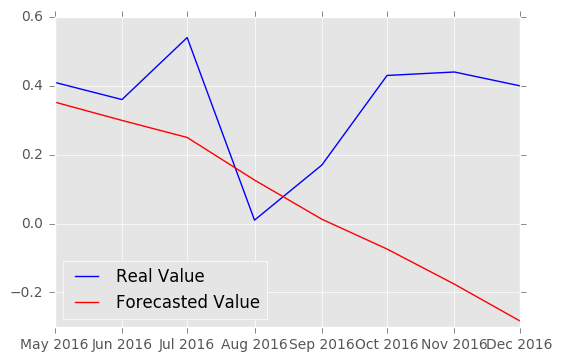

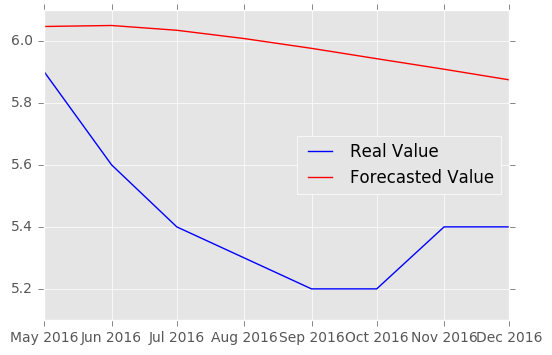

In [66]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

### Hybrid_full

In [67]:
#def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100, period='m'):
# lags = LAG
# steps=STEPS
# model_nn=nn
# years=True
# epoch=200
# period='q'

def hybrid_model_undiff(train, train_real, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    var_in = undiff(previous_df=train_real.head(1), diff_df=pd.DataFrame(fitm.fittedvalues))
    var_out = undiff(previous_df=train_real, diff_df=pd.DataFrame(var_result))
    resid_df = pd.DataFrame(train_real.iloc[lags+1:, :].as_matrix() - var_in.as_matrix())
    resid_df.columns = train.columns

    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_out.as_matrix() + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns

    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3

    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

Первый запуск

In [68]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
1s - loss: 1.3871
Epoch 2/500
0s - loss: 0.9816
Epoch 3/500
0s - loss: 0.8881
Epoch 4/500
0s - loss: 0.8214
Epoch 5/500
0s - loss: 0.7522
Epoch 6/500
0s - loss: 0.6747
Epoch 7/500
0s - loss: 0.5997
Epoch 8/500
0s - loss: 0.5322
Epoch 9/500
0s - loss: 0.4798
Epoch 10/500
0s - loss: 0.4423
Epoch 11/500
0s - loss: 0.4181
Epoch 12/500
0s - loss: 0.4014
Epoch 13/500
0s - loss: 0.3922
Epoch 14/500
0s - loss: 0.3842
Epoch 15/500
0s - loss: 0.3779
Epoch 16/500
0s - loss: 0.3730
Epoch 17/500
0s - loss: 0.3660
Epoch 18/500
0s - loss: 0.3618
Epoch 19/500
0s - loss: 0.3569
Epoch 20/500
0s - loss: 0.3517
Epoch 21/500
0s - loss: 0.3489
Epoch 22/500
0s - loss: 0.3446
Epoch 23/500
0s - loss: 0.3389
Epoch 24/500
0s - loss: 0.3358
Epoch 25/500
0s - loss: 0.3317
Epoch 26/500
0s - loss: 0.3284
Epoch 27/500
0s - loss: 0.3237
Epoch 28/500
0s - loss: 0.3189
Epoch 29/500
0s - loss: 0.3161
Epoch 30/500
0s - loss: 0.3135
Epoch 31/500
0s - loss: 0.3092
Epoch 32/500
0s - loss: 0.3058
Epoch 33/500
0s -

{'mse': 250.5078106810343, 'mae': 10.949410626245362, 'rmse': 15.827438538216924}
{'mse': 2.1233437278885923, 'mae': 1.302624492321292, 'rmse': 1.4571697663239491}
{'mse': 0.67394703949857182, 'mae': 0.81282204833524696, 'rmse': 0.82094277480136935}


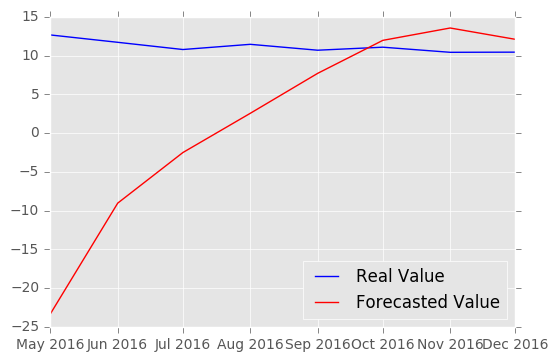

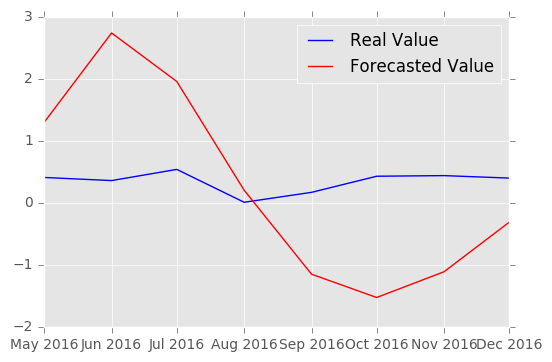

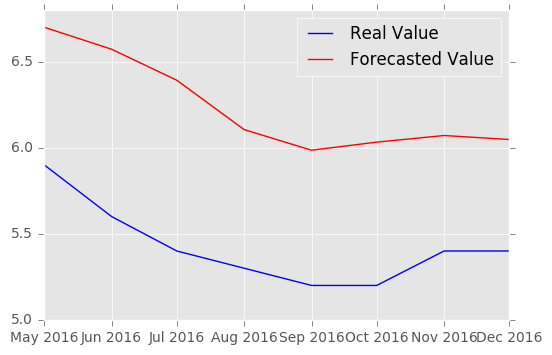

In [69]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])

Второй запуск

In [70]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
1s - loss: 1.2019
Epoch 2/500
0s - loss: 0.9408
Epoch 3/500
0s - loss: 0.8704
Epoch 4/500
0s - loss: 0.8056
Epoch 5/500
0s - loss: 0.7357
Epoch 6/500
0s - loss: 0.6658
Epoch 7/500
0s - loss: 0.6015
Epoch 8/500
0s - loss: 0.5491
Epoch 9/500
0s - loss: 0.5071
Epoch 10/500
0s - loss: 0.4738
Epoch 11/500
0s - loss: 0.4477
Epoch 12/500
0s - loss: 0.4288
Epoch 13/500
0s - loss: 0.4137
Epoch 14/500
0s - loss: 0.4014
Epoch 15/500
0s - loss: 0.3936
Epoch 16/500
0s - loss: 0.3858
Epoch 17/500
0s - loss: 0.3801
Epoch 18/500
0s - loss: 0.3741
Epoch 19/500
0s - loss: 0.3693
Epoch 20/500
0s - loss: 0.3638
Epoch 21/500
0s - loss: 0.3594
Epoch 22/500
0s - loss: 0.3543
Epoch 23/500
0s - loss: 0.3499
Epoch 24/500
0s - loss: 0.3456
Epoch 25/500
0s - loss: 0.3447
Epoch 26/500
0s - loss: 0.3380
Epoch 27/500
0s - loss: 0.3348
Epoch 28/500
0s - loss: 0.3317
Epoch 29/500
0s - loss: 0.3287
Epoch 30/500
0s - loss: 0.3233
Epoch 31/500
0s - loss: 0.3203
Epoch 32/500
0s - loss: 0.3189
Epoch 33/500
0s -

{'mse': 1032.7627916322153, 'mae': 31.920459533221798, 'rmse': 32.136626948580265}
{'mse': 40.212979331750418, 'mae': 6.0064136601624698, 'rmse': 6.3413704616392206}
{'mse': 2.4121997864504037, 'mae': 1.5156386889359632, 'rmse': 1.5531258115331172}


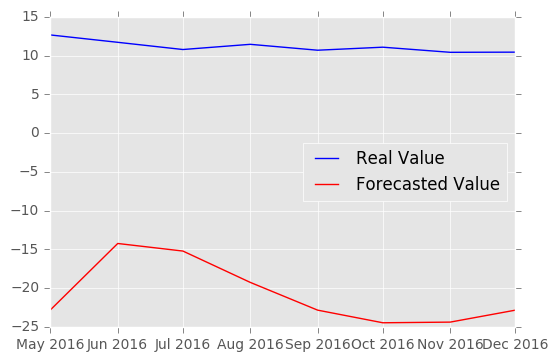

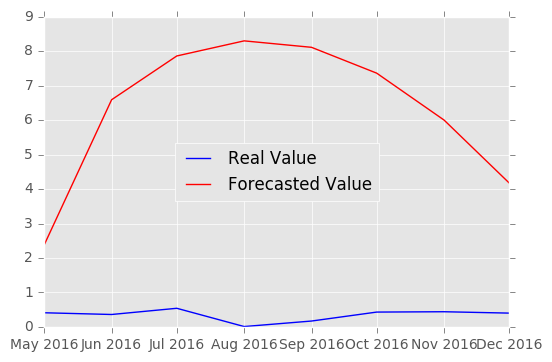

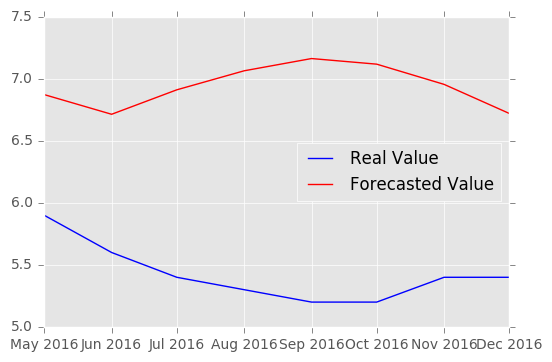

In [71]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])

С DropOut

In [72]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
1s - loss: 1.0631
Epoch 2/500
0s - loss: 1.0176
Epoch 3/500
0s - loss: 1.0055
Epoch 4/500
0s - loss: 1.0000
Epoch 5/500
0s - loss: 0.9988
Epoch 6/500
0s - loss: 0.9952
Epoch 7/500
0s - loss: 0.9885
Epoch 8/500
0s - loss: 0.9880
Epoch 9/500
0s - loss: 0.9759
Epoch 10/500
0s - loss: 0.9824
Epoch 11/500
0s - loss: 0.9589
Epoch 12/500
0s - loss: 0.9449
Epoch 13/500
0s - loss: 0.9198
Epoch 14/500
0s - loss: 0.9147
Epoch 15/500
0s - loss: 0.9092
Epoch 16/500
0s - loss: 0.8817
Epoch 17/500
0s - loss: 0.8401
Epoch 18/500
0s - loss: 0.8499
Epoch 19/500
0s - loss: 0.8152
Epoch 20/500
0s - loss: 0.8149
Epoch 21/500
0s - loss: 0.8227
Epoch 22/500
0s - loss: 0.8047
Epoch 23/500
0s - loss: 0.7693
Epoch 24/500
0s - loss: 0.7868
Epoch 25/500
0s - loss: 0.7989
Epoch 26/500
0s - loss: 0.7551
Epoch 27/500
0s - loss: 0.7549
Epoch 28/500
0s - loss: 0.7598
Epoch 29/500
0s - loss: 0.7460
Epoch 30/500
0s - loss: 0.7515
Epoch 31/500
0s - loss: 0.7753
Epoch 32/500
0s - loss: 0.7053
Epoch 33/500
0s -

{'mse': 678.65633338582779, 'mae': 25.939338158857048, 'rmse': 26.051033249869914}
{'mse': 1.5978569062464005, 'mae': 1.1915467590334643, 'rmse': 1.2640636480203047}
{'mse': 0.8558063824375477, 'mae': 0.91170633544659374, 'rmse': 0.92509803936531376}


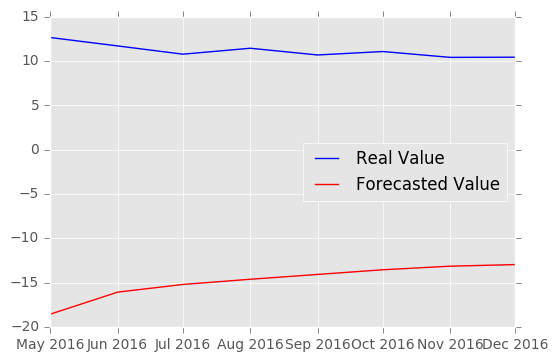

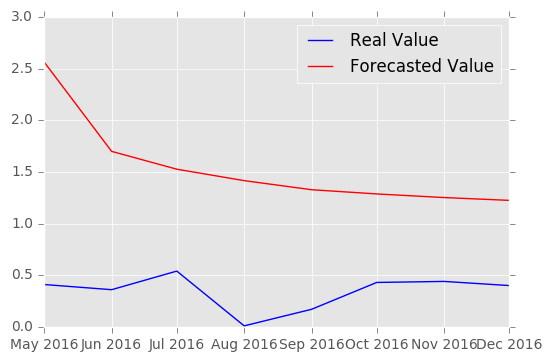

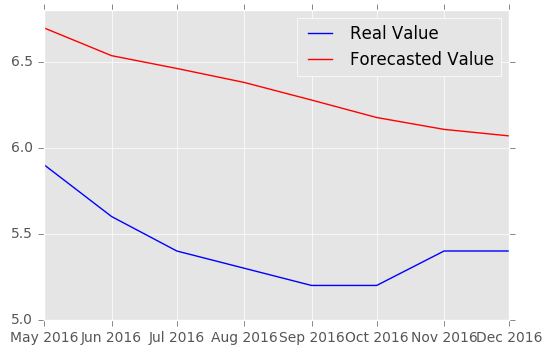

In [73]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])